In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import time
import os

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    
    if(os.path.isdir('./pkl_cache')==False):
        os.makedirs('./pkl_cache')
    
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'pkl_cache/cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'pkl_cache/cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [3]:
prior_model = StanModel_cache(model_code=open("../Stan files/prior.stan").read())

Using cached StanModel


In [4]:
prior_supp_GP_model = StanModel_cache(model_code=open("../Stan files/prior with support GP with linear mean.stan").read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40f997f62a9bee5048b4c39ddc8fe872 NOW.


In [5]:
N = 20
xp = np.linspace(-10,4,N)
m_m = np.ones_like(xp,dtype=int)
v_value = 0.00001

prior_data = dict(
    N = N,
    x = xp
)


prior_supp_GP_data = dict(
    N = N,
    x = xp,
    N_g = N,
    x_g = xp,
    m_m = m_m,
    v = v_value
)


N_g = 70
x_g = np.linspace(-10,10,N_g)


In [6]:
prior_fit = prior_model.sampling(data=prior_data,iter=2000,chains=1)


In [7]:
prior_arr = prior_fit.extract(permuted=True)
prior = prior_arr['f']

#### Note:Sampling prior with GP support shows initialization failed often ####

In [8]:
uni_prior_fit = prior_supp_GP_model.sampling(data=prior_supp_GP_data,iter=2000,chains=1)
print(uni_prior_fit)

RuntimeError: Initialization failed.

In [9]:
uni_prior_arr = uni_prior_fit.extract(permuted=True)
sim_uni_prior = uni_prior_arr['f']
sim_uni_param = uni_prior_arr['m']

NameError: name 'uni_prior_fit' is not defined

In [10]:
p = np.random.randint(sim_uni_prior.shape[0],size=3)
pp = np.random.randint(prior.shape[0],size=3)
pr_q5 = np.percentile(prior,5,axis=0)
pr_q95 = np.percentile(prior,95,axis=0)
pr_mean = np.mean(prior,axis=0)
m_pr_q5 = np.percentile(sim_uni_prior[0:,:N],5,axis=0)
m_pr_q95 = np.percentile(sim_uni_prior[0:,:N],95,axis=0)
m_pr_mean = np.mean(sim_uni_prior[0:,:N],axis=0)




plt.figure(figsize=(15,20))

ax1 = plt.subplot(411)
plt.title('Samples of prior functions without unimodality constraints')
plt.plot(xp, prior[pp[0]], 'c')
plt.plot(xp, prior[pp[1]], 'y')
plt.plot(xp, prior[pp[2]], 'm')
plt.fill_between(xp, pr_q5, pr_q95, color="#dddddd",label="Region between 5-95 quantiles")
plt.plot(xp,pr_mean,'r--',lw=2,label="Mean" )
plt.legend()


plt.subplot(412)
plt.title('Samples of prior functions with Unimodal constraints v={}'.format(v_value))
plt.plot(xp, sim_uni_prior[p[0]][:N], 'c')
plt.plot(xp, sim_uni_prior[p[1]][:N], 'g')
plt.plot(xp, sim_uni_prior[p[2]][:N], 'b')
plt.fill_between(xp, m_pr_q5, m_pr_q95, color="#dddddd")
plt.fill_between(xp, np.percentile(sim_uni_prior[0:,:N],5,axis=0),np.percentile(sim_uni_prior[0:,:N],5,axis=0), color="#dddddd")
plt.plot(xp,m_pr_mean,'r--',lw=2,label="Mean" )
plt.legend()

plt.subplot(413)
plt.title('Derivative of prior functions with Unimodal constraits')
plt.plot(xp, sim_uni_prior[p[0]][N:], 'c')
plt.plot(xp, sim_uni_prior[p[1]][N:], 'g')
plt.plot(xp, sim_uni_prior[p[2]][N:], 'b')
plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)


plt.subplot(414,sharex=ax1)
plt.title('Monotonic Gaussian process generating the slope parameter \'m\'')
plt.plot(xp, sim_uni_param[p[0]][:N], 'c')
plt.plot(xp, sim_uni_param[p[1]][:N], 'g')
plt.plot(xp, sim_uni_param[p[1]][:N], 'b')
plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
plt.fill_between(xp, np.percentile(sim_uni_param[0:,:N],5,axis=0),np.percentile(sim_uni_param[0:,:N],5,axis=0), color="#dddddd")
plt.plot(xp,np.mean(sim_uni_param[0:,:N],axis=0),'r--',lw=2,label="Mean" )

plt.legend()



plt.legend()
plt.savefig("./Fig/%s Unimodal Prior.png"%(time.ctime()))
plt.show()

NameError: name 'sim_uni_prior' is not defined

# Posterior 

In [25]:
posterior_model = StanModel_cache(model_code=open("../Stan files/posterior.stan").read())

Using cached StanModel


In [26]:
uni_posterior_model = StanModel_cache(model_code=open("../Stan files/posterior with support GP with linear mean.stan").read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46aaf7d6bc7c21712234d13690d4e267 NOW.


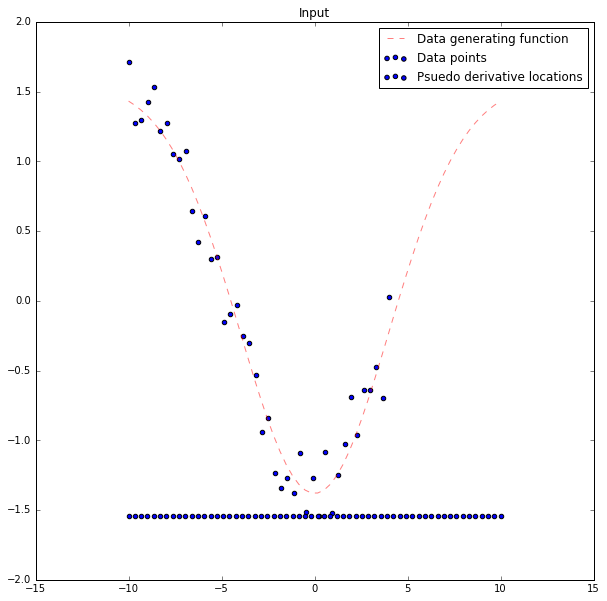

In [27]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def func(x):
    return 1-gaussian(x,0,4) #+ gaussian(x,-5,0.4)*0.05


leng = 60
lendata = 42
#lenpred = 20

xdata = np.linspace(-10,4,lendata)
ydata = func(xdata) + np.random.normal(0,0.005,size=len(xdata))
x = np.linspace(-10,10,leng)
y = func(x) 
#xpred = np.linspace(4,10,lenpred)
ycombined = preprocessing.scale(np.append(ydata,y))
ydata = ycombined[:len(xdata)]
y = ycombined[len(xdata):]

plt.figure(figsize=(10,10))
plt.scatter(xdata,ydata,label="Data points")
plt.plot(x,y,'r--',alpha=0.5,label="Data generating function")
plt.scatter(x,np.zeros_like(x)+np.min(ycombined),label="Psuedo derivative locations")
plt.title('Input')

plt.legend()
plt.savefig("./Fig/%s Input data points.png"%(time.ctime()))

plt.show()

In [34]:
sig =0.01
v= 0.001

posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_prm = len(x),
    x_prm = x,
    sig_var = sig
)

uni_posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_g = len(x),
    x_g = x,
    m_m = np.ones_like(x,dtype=int),
    N_prm = len(x),
    x_prm = x,
    v = v,
    sig_var = sig
)

In [35]:
posterior_fit = posterior_model.sampling(data=posterior_data,iter=1000,chains=1)
print(posterior_fit)

Inference for Stan model: anon_model_4c8635eb3d0081962d7e50e2f766a468.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho         1.69    0.27   0.84   0.65   1.31   1.53   1.82   4.07   10.0    1.1
alpha       0.99    0.02   0.24   0.61   0.83   0.95   1.13   1.57  156.0    1.0
eta[0]      1.66    0.03   0.37   0.99   1.38   1.65   1.89   2.48  148.0    1.0
eta[1]     -0.24    0.03   0.29  -0.76  -0.43  -0.26  -0.05   0.39  110.0   1.02
eta[2]      1.36    0.17   0.79  -0.53   0.93   1.45   1.95   2.57   22.0   1.04
eta[3]     -0.18    0.08   0.75  -1.67  -0.67  -0.16   0.31   1.25   98.0   1.01
eta[4]       0.1    0.03   0.72  -1.44  -0.33   0.14   0.56   1.41  500.0    1.0
eta[5]      0.28    0.04   0.82  -1.38  -0.21    0.3   0.79   1.96  500.0   1.01
eta[6]      0.15    0.04   0.88  -1.62  -0.43   0.12   0.79   1.73  500.0   1.01
eta[

In [36]:
uni_posterior_fit = uni_posterior_model.sampling(data=uni_posterior_data,iter=1000,chains=1)
print(uni_posterior_fit)

Inference for Stan model: anon_model_46aaf7d6bc7c21712234d13690d4e267.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho          3.87    0.16   0.91   2.28   3.23   3.77   4.41   5.75   32.0   1.06
alpha        1.05    0.05   0.31   0.61   0.82   1.01   1.21   1.89   46.0   1.01
rho_g        7.42    0.45    3.8   3.52   5.14   6.38   8.29  20.13   70.0    1.0
alpha_g      1.07    0.05   0.56   0.27   0.67   0.99   1.34   2.29  126.0   1.01
eta[0]       1.58    0.06   0.43   0.81   1.28   1.54   1.88   2.49   46.0    1.0
eta[1]      -0.38    0.03   0.26  -0.98  -0.55  -0.34  -0.19   0.06   77.0   1.02
eta[2]       0.37    0.09   0.89  -1.49  -0.21   0.32   1.04   2.07   92.0    1.0
eta[3]       0.09    0.06   0.79  -1.52  -0.48   0.12   0.59   1.67  146.0    1.0
eta[4]      -0.06    0.07   0.88  -1.69  -0.71  -0.03   0.53    1.8  164.0  

In [37]:
sim_posterior = posterior_fit.extract(permuted=True)['y_prm']
p_mean = np.mean(sim_posterior,axis=0)
p_std = np.std(sim_posterior,axis=0)
p_q5 = np.percentile(sim_posterior, 5, axis=0)
p_q95 = np.percentile(sim_posterior, 95, axis=0)


In [38]:
uni_sim_posterior = uni_posterior_fit.extract(permuted=True)['y_prm']
u_p_mean = np.mean(uni_sim_posterior,axis=0)
u_p_std = np.std(uni_sim_posterior,axis=0)
u_p_q5 = np.percentile(uni_sim_posterior, 5, axis=0)
u_p_q95 = np.percentile(uni_sim_posterior, 95, axis=0)

uni_sim_param = uni_posterior_fit.extract(permuted=True)['m']
uni_sim_der   = uni_posterior_fit.extract(permuted=True)['f']

a =  uni_posterior_fit.extract(permuted=True)['a']
b = uni_posterior_fit.extract(permuted=True)['b']

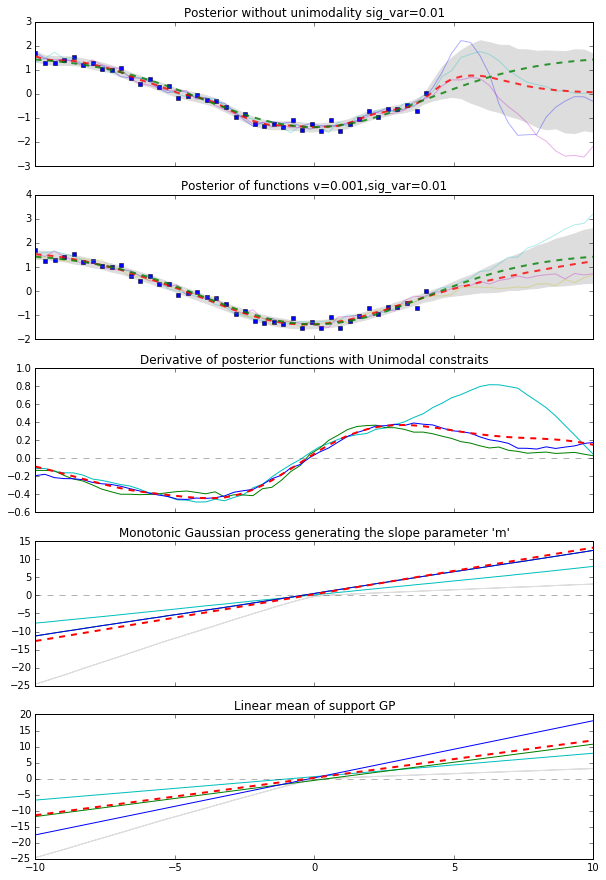

In [39]:
c = ['b', 'c', 'm', 'y']
p = np.random.randint(sim_posterior.shape[0],size=3)
pp = np.random.randint(uni_sim_posterior.shape[0],size=3)


fig,ax = plt.subplots(5,1,sharex=True)
fig.set_size_inches(10,15)
ax[0].set_title('Posterior without unimodality sig_var={}'.format(sig))
ax[0].plot(xdata, ydata, 'bs', ms=4,label="Data points")#  
ax[0].plot(x, sim_posterior[p[0]], c[0],alpha=0.3,label="posterior1")
ax[0].plot(x, sim_posterior[p[1]], c[1],alpha=0.3,label="posterior2")
ax[0].plot(x, sim_posterior[p[2]], c[2],alpha=0.3,label="posterior3")
ax[0].plot(x, p_mean,'r--',alpha=0.8,lw=2,label="mean of posterior simulations")
ax[0].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[0].fill_between(x, p_q5, p_q95, color="#dddddd")
#ax[0].legend()


#plt.subplot(2,2,2)
ax[1].set_title('Posterior of functions v={},sig_var={}'.format(v,sig))
ax[1].plot(xdata, ydata, 'bs', ms=4,label="Data points")#
ax[1].fill_between(x, u_p_q5, u_p_q95, color="#dddddd")
ax[1].plot(x, uni_sim_posterior[pp[0]], c[1],alpha=0.3,label="posterior-function1")
ax[1].plot(x, uni_sim_posterior[pp[1]], c[2],alpha=0.3,label="posterior-function2")
ax[1].plot(x, uni_sim_posterior[pp[2]], c[3],alpha=0.3,label="posterior-function3")
ax[1].plot(x, u_p_mean, 'r--',alpha=0.8, lw=2,label="mean of posterior simulations")
ax[1].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
#ax[1].legend()


#plt.subplot(413)
ax[2].set_title('Derivative of posterior functions with Unimodal constraits')
ax[2].plot(x, uni_sim_der[p[0]][leng+lendata:], 'c')
ax[2].plot(x, uni_sim_der[p[1]][leng+lendata:], 'g')
ax[2].plot(x, uni_sim_der[p[2]][leng+lendata:], 'b')
ax[2].plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
ax[2].plot(x,np.mean(uni_sim_der[0:,leng+lendata:],axis=0),'r--',lw=2,label="Mean" )

#ax[2].legend()


#ax[3].subplot(414,sharex=ax1)
ax[3].set_title('Monotonic Gaussian process generating the slope parameter \'m\'')
ax[3].plot(x, uni_sim_param[p[0]][:leng], 'c')
ax[3].plot(x, uni_sim_param[p[1]][:leng], 'g')
ax[3].plot(x, uni_sim_param[p[1]][:leng], 'b')
ax[3].plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
ax[3].fill_between(x, np.percentile(uni_sim_param[0:,:leng],5,axis=0),np.percentile(uni_sim_param[0:,:leng],5,axis=0), color="#dddddd")
ax[3].plot(x,np.mean(uni_sim_param[0:,:leng],axis=0),'r--',lw=2,label="Mean" )


ax[4].set_title('Linear mean of support GP')
ax[4].plot(x, a[p[0]]*x+b[p[0]], 'c')
ax[4].plot(x, a[p[1]]*x+b[p[1]], 'g')
ax[4].plot(x, a[p[2]]*x+b[p[2]], 'b')
ax[4].plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
ax[4].fill_between(x, np.percentile(uni_sim_param[0:,:leng],5,axis=0),np.percentile(uni_sim_param[0:,:leng],5,axis=0), color="#dddddd")
ax[4].plot(x,np.mean(a)*x+np.mean(b),'r--',lw=2,label="Mean" )


plt.savefig("./Fig/%s Posterior.png"%(time.ctime()))
plt.show()